### Find quench levels

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, rcParams

In [2]:
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import add_custom_legend

In [3]:
from util_commons import GASES, PLANETS, ROSE_SUITES

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
iris.FUTURE.datum_support = True
rcParams["mathtext.default"] = "regular"

In [5]:
# Parameters
planet = "wasp96b"
path_to_project = Path.home() / "projects" / planet
tK = "tK_6"
t0 = -20  # last 200 days
tgt_plevs = np.logspace(7, 2, 65)  # target pressure levels
tgt_lons = [91.25, 271.25]  # target longitudes
interp_args = ([("longitude", tgt_lons)], iris.analysis.Linear())
sp_names_short = ["ch4", "co2", "hcn", "nh3"]
sp_names_long = [f"{sp_name.upper()} mole fraction" for sp_name in sp_names_short]

In [6]:
vrbls = {}
for exp in ["equilibrium", "kinetics"]:
    vrbls[exp] = {}
    for mdh in ["mdh_0", "mdh_1"]:
        vrbls[exp][mdh] = {}
        fpath = ROSE_SUITES[planet][exp][mdh][tK]["dir_for_data"] / "merged"
        fname = f"{ROSE_SUITES[planet][exp][mdh][tK]['rose_suite']}.nc"
        pres = iris.load_cube(fpath / fname, um.pres)[t0:, ...]
        temp = iris.load_cube(fpath / fname, um.temp)[t0:, ...]
        u = iris.load_cube(fpath / fname, um.u)[t0:, ...]
        v = iris.load_cube(fpath / fname, um.v)[t0:, ...]
        w = iris.load_cube(fpath / fname, um.w)[t0:, ...]
        _sps = iris.load(fpath / fname, sp_names_long)
        sps = iris.cube.CubeList()
        for i in _sps:
            sps.append(i[t0:, ...])
        # Interpolate v and w to u grid
        v_rgrd = v.regrid(u, iris.analysis.Linear())
        w_rgrd = u.regrid(u, iris.analysis.Linear())
        # Interpolate to pressure levels
        temp_plevs = interp_cube_from_height_to_pressure_levels(temp, pres, tgt_plevs)
        u_plevs = interp_cube_from_height_to_pressure_levels(u, pres, tgt_plevs)
        v_plevs = interp_cube_from_height_to_pressure_levels(v_rgrd, pres, tgt_plevs)
        w_plevs = interp_cube_from_height_to_pressure_levels(w_rgrd, pres, tgt_plevs)
        temp_plevs_locs = temp_plevs.interpolate(*interp_args)
        u_plevs_locs = u_plevs.interpolate(*interp_args)
        v_plevs_locs = v_plevs.interpolate(*interp_args)
        w_plevs_locs = w_plevs.interpolate(*interp_args)
        # Find mean over the last 200 days
        temp_plevs_locs_mean = temp_plevs_locs.collapsed("time", iris.analysis.MEAN)
        u_plevs_locs_mean = u_plevs_locs.collapsed("time", iris.analysis.MEAN)
        v_plevs_locs_mean = v_plevs_locs.collapsed("time", iris.analysis.MEAN)
        w_plevs_locs_mean = w_plevs_locs.collapsed("time", iris.analysis.MEAN)
        sps_plevs_locs = iris.cube.CubeList()
        for sp in sps:
            cb_plevs = interp_cube_from_height_to_pressure_levels(sp, pres, tgt_plevs)
            cb_plevs_locs = cb_plevs.interpolate(*interp_args)
            cb_plevs_locs_mean = cb_plevs_locs.collapsed("time", iris.analysis.MEAN)
            sps_plevs_locs.append(cb_plevs_locs_mean)
        pres_coord = sps_plevs_locs[0].coord("air_pressure")
        # Assemble data
        vrbls[exp][mdh] = {
            "temp_plevs_locs_mean": temp_plevs_locs_mean,
            "u_plevs_locs_mean": u_plevs_locs_mean,
            "v_plevs_locs_mean": v_plevs_locs_mean,
            "w_plevs_locs_mean": w_plevs_locs_mean,
            "sps_plevs_locs": sps_plevs_locs,
        }

In [7]:
# Summary array manually created in the next cell
sp_qpts_dlat_mor_quarter = np.array(
    [
        [-89.0, 5.5e5, 1.3e-6],
        [-87.0, 5.5e5, 1.3e-6],
        [-85.0, 5.5e5, 1.3e-6],
        [-83.0, 5.5e5, 1.3e-6],
        [-81.0, 5.5e5, 1.3e-6],
        [-79.0, 5.5e5, 1.3e-6],
        [-77.0, 5.5e5, 1.3e-6],
        [-75.0, 5.5e5, 1.3e-6],
        [-73.0, 5.5e5, 1.3e-6],
        [-71.0, 5.5e5, 1.3e-6],
        [-69.0, 5.2e5, 1.3e-6],
        [-67.0, 5.2e5, 1.3e-6],
        [-65.0, 5.2e5, 1.3e-6],
        [-63.0, 5.2e5, 1.3e-6],
        [-61.0, 5.2e5, 1.3e-6],
        [-59.0, 5.2e5, 1.3e-6],
        [-57.0, 4.1e5, 9.8e-7],
        [-55.0, 4.1e5, 9.8e-7],
        [-53.0, 4.1e5, 9.8e-7],
        [-51.0, 4.1e5, 9.8e-7],
        [-49.0, 1.4e5, 4.0e-7],
        [-47.0, 1.2e5, 3.8e-7],
        [-45.0, 1.0e5, 3.5e-7],
        [-43.0, 4.8e4, 3.3e-7],
        [-41.0, 4.4e4, 3.1e-7],
        [-39.0, 4.2e4, 2.9e-7],
        [-37.0, 3.8e4, 2.5e-7],
        [-35.0, 3.5e4, 2.2e-7],
        [-33.0, 3.2e4, 2.1e-7],
        [-31.0, 2.8e4, 1.8e-7],
        [-29.0, 2.7e4, 1.5e-7],
        [-27.0, 2.5e4, 1.3e-7],
        [-25.0, 2.3e4, 1.0e-7],
        [-23.0, 2.0e4, 8.2e-8],
        [-21.0, 1.9e4, 6.5e-8],
        [-19.0, 1.7e4, 5.3e-8],
        [-17.0, 1.5e4, 4.4e-8],
        [-15.0, 1.5e4, 3.5e-8],
        [-13.0, 1.5e4, 3.3e-8],
        [-11.0, 1.5e4, 2.9e-8],
        [-9.0, 1.5e4, 2.9e-8],
        [-7.0, 1.5e4, 3.0e-8],
        [-5.0, 1.5e4, 3.0e-8],
        [-3.0, 1.5e4, 3.1e-8],
        [-1.0, 1.5e4, 3.3e-8],
    ]
)

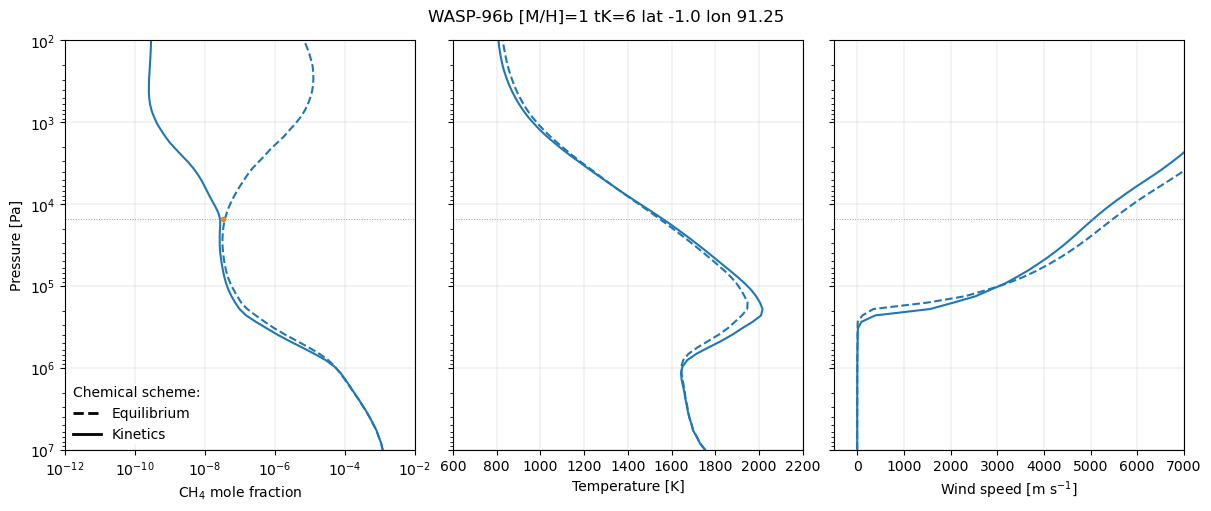

In [8]:
# Choose quarter
mdh = "mdh_1"
lon = 91.25
# Choose latitude
l0, l1 = 44, 45  # 0, 45

for lat, plt_sp_qplev, plt_sp_qabun in zip(
    temp.coord("latitude").points[l0:l1],
    sp_qpts_dlat_mor_quarter.T[1][l0:l1],
    sp_qpts_dlat_mor_quarter.T[2][l0:l1],
):
    fig, axes = plt.subplots(
        ncols=3,
        nrows=1,
        figsize=(12, 5),
        sharey=True,
        constrained_layout=True,
    )
    for ax in axes.flatten():
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Pressure [Pa]")
        ax.set_yscale("log")
        ax.set_ylim(1e7, 1e2)
        ax.grid(lw=0.2)
    for exp, ls in zip(["equilibrium", "kinetics"], ["--", "-"]):
        vp_chem = (
            vrbls[exp][mdh]["sps_plevs_locs"]
            .extract("CH4 mole fraction")[0]  # CH4 CO2 HCN NH3
            .extract(iris.Constraint(latitude=lat, longitude=lon))
            .data
        )
        vp_temp = (
            vrbls[exp][mdh]["temp_plevs_locs_mean"]
            .extract(iris.Constraint(latitude=lat, longitude=lon))
            .data
        )
        vp_wind = np.sqrt(
            (
                vrbls[exp][mdh]["u_plevs_locs_mean"]
                .extract(iris.Constraint(latitude=lat, longitude=lon))
                .data
            )
            ** 2
            + (
                vrbls[exp][mdh]["v_plevs_locs_mean"]
                .extract(iris.Constraint(latitude=lat, longitude=lon))
                .data
            )
            ** 2
            + (
                vrbls[exp][mdh]["w_plevs_locs_mean"]
                .extract(iris.Constraint(latitude=lat, longitude=lon))
                .data
            )
            ** 2
        )
        axes[0].plot(vp_chem, pres_coord.points, ls=ls, color="C0")
        axes[1].plot(vp_temp, pres_coord.points, ls=ls, color="C0")
        axes[2].plot(vp_wind, pres_coord.points, ls=ls, color="C0")
    axes[0].set_xlabel("$CH_4$ mole fraction")
    axes[0].set_xscale("log")
    axes[0].set_xlim(1e-12, 1e-2)
    axes[1].set_xlabel("Temperature [K]")
    axes[1].set_xlim(600, 2200)
    axes[2].set_xlabel("Wind speed [m $s^{-1}$]")
    axes[2].set_xlim(-500, 7000)
    leg_exp_kw = {
        "Equilibrium": {"linestyle": "--", "linewidth": 2, "color": "k"},
        "Kinetics": {"linestyle": "-", "linewidth": 2, "color": "k"},
    }
    add_custom_legend(
        axes[0],
        leg_exp_kw,
        title="Chemical scheme:",
        loc="lower left",
        alignment="left",
        frameon=True,
        facecolor="white",
        edgecolor="white",
        framealpha=1,
        borderpad=0.1,
    )
    fig.suptitle(f"{PLANETS[planet]['tex']} [M/H]={mdh[-1]} tK={tK[-1]} lat {lat} lon {lon}")
    figname = f"{planet}_{mdh}_{tK}_vp_pres_ch4quench_temp_wind3d_lat{lat}_lon{lon}.png"

    # Manual identification of quench level
    plt_sp_qplev, plt_sp_qabun = 1.5e4, 3.3e-8
    axes[0].scatter(
        [plt_sp_qabun],
        [plt_sp_qplev],
        marker=".",
        color=["C1"],
        zorder=2,
    )
    for iax in axes.flatten():
        iax.axhline(plt_sp_qplev, color="C1", ls="dotted", lw=0.7)

    # fig.savefig(
    #     path_to_project
    #     / "chemistry"
    #     / "quench_level"
    #     / "ch4"
    #     / "manual"
    #     / mdh
    #     / "morning"
    #     / figname,
    #     bbox_inches="tight",
    # )
    # plt.close()